In [1]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
import seaborn as sns
import panel as pn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from bokeh.sampledata.penguins import data as df
import matplotlib.pyplot as plt
import hvplot.pandas
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [2]:
data = pd.read_csv('bank/bank-full.csv', delimiter=";")

In [3]:
data

age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
0        unknown    5   may       261         1     -1         0  unknown   no  
1        unknown    5   may       151         1     -1         0  unknown   no  
2        unknown    5   may        76         1     -1         0  unknown   no  
3        unknown    5   may        92         1     -1         0  unknown   no  
4        unknown    5   may       198         1     -1         0  unknown   no  
...          ...  ...   ...       ...       ...    ...       ...      ...  ...  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45207   cellular   17   nov       456         2     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no  

[45211 rows x 17 columns]

# Data Preprocessing

In [4]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [7]:
data.describe()

age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

In [8]:
(data.poutcome.unique())

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [9]:
objList = data.select_dtypes(include = "object").columns
print (objList)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')


In [10]:
#Label Encoding for object to numeric conversion
le = LabelEncoder()

for values in objList:
    data[values] = le.fit_transform(data[values].astype(str))

data = data

In [11]:
data

age  job  marital  education  default  balance  housing  loan  contact  \
0       58    4        1          2        0     2143        1     0        2   
1       44    9        2          1        0       29        1     0        2   
2       33    2        1          1        0        2        1     1        2   
3       47    1        1          3        0     1506        1     0        2   
4       33   11        2          3        0        1        0     0        2   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
45206   51    9        1          2        0      825        0     0        0   
45207   71    5        0          0        0     1729        0     0        0   
45208   72    5        1          1        0     5715        0     0        0   
45209   57    1        1          1        0      668        0     0        1   
45210   37    2        1          1        0     2971        0     0        0   

       day  month  duration  campaign  pdays  previous  poutcome  y  
0        5      8       261         1     -1         0         3  0  
1        5      8       151         1     -1         0         3  0  
2        5      8        76         1     -1         0         3  0  
3        5      8        92         1     -1         0         3  0  
4        5      8       198         1     -1         0         3  0  
...    ...    ...       ...       ...    ...       ...       ... ..  
45206   17      9       977         3     -1         0         3  1  
45207   17      9       456         2     -1         0         3  1  
45208   17      9      1127         5    184         3         2  1  
45209   17      9       508         4     -1         0         3  0  
45210   17      9       361         2    188        11         1  0  

[45211 rows x 17 columns]

In [12]:
(data.education.unique())

array([2, 1, 3, 0])

# Data Visualization

In [13]:
corr_matrix = data.corr()
corr_matrix["y"].sort_values(ascending=False)

y            1.000000
duration     0.394521
pdays        0.103621
previous     0.093236
education    0.066241
balance      0.052838
marital      0.045588
job          0.040438
age          0.025155
default     -0.022419
month       -0.024471
day         -0.028348
loan        -0.068185
campaign    -0.073172
poutcome    -0.077840
housing     -0.139173
contact     -0.148395
Name: y, dtype: float64

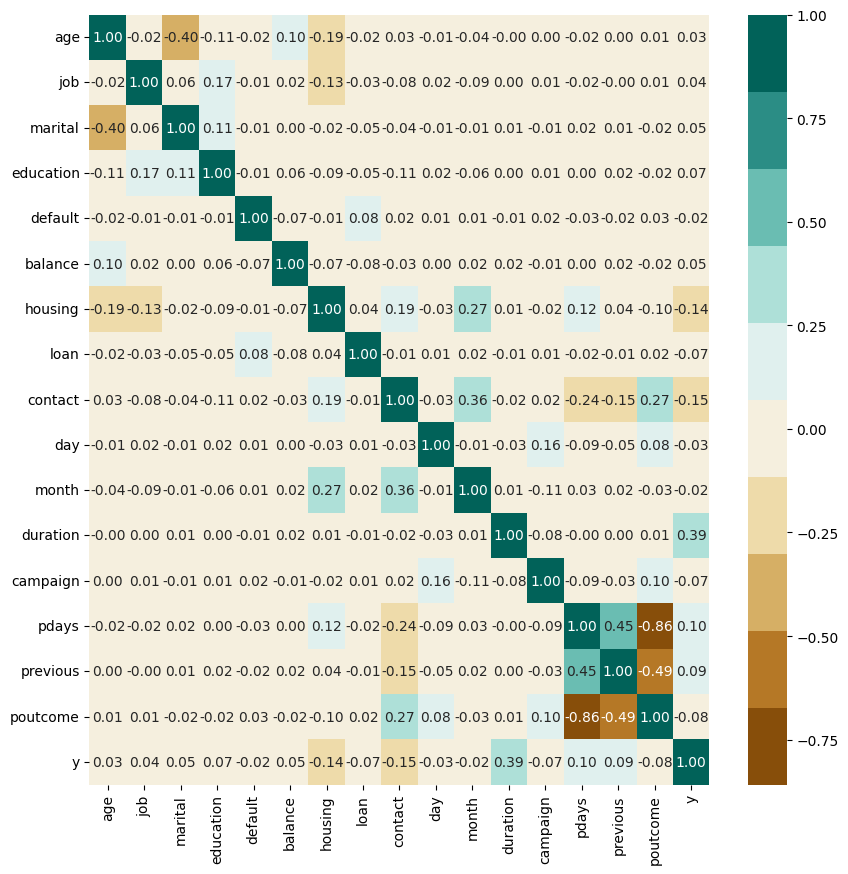

In [15]:
## Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
# Generate Color Map
# colormap = sns.diverging_palette(220, 10, as_cmap=True)
colormap = sns.color_palette("BrBG", 10)
# Generate Heat Map, allow annotations and place floats in map 
sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".2f") #ax.set_yticklabels(column_names);
plt.show()

In [16]:
data.hvplot.scatter(x='pdays', y='previous', by='education')

:NdOverlay   [education]
   :Scatter   [pdays]   (previous)

In [17]:
option = pn.widgets.MultiSelect(name='default', value=[0], options=[1, 0])
value = pn.widgets.FloatSlider(name='age', start=18, end=100, step=5)

dfi = data.interactive(loc='left')
dfi.loc[(dfi['default'].isin(option)) & (dfi['age'] > value)]['y'].describe()

In [18]:
hvexplorer = data.hvplot.explorer()
hvexplorer

hvDataFrameExplorer(advanced=Advanced(explorer=..., name='Advanced01634', opts=None), axes=Axes(explorer=..., height=None, legend='bottom_right', logx=False, logy=False, name='Axes01628', responsive=True, shared_axes=True, width=None, xlim=None, ylim=None), by=[], code="df.hvplot(\n    kind='scatter',\n    x='index',\n    legend='bottom_right',\n    widget_location='bottom',\n)", colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping01629', rescale_discrete_levels=True, symmetric=False), geographic=Geographic(crs=None, crs_kwargs={}, explorer=..., feature_scale='110m', features=None, geo=False, global_extent=None, name='Geographic01631', project=False, projection=None, projection_kwargs={}, tiles=None), groupby=[], kind='scatter', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels01630', rot=0, title='', xlabel='', ylabel=''), name='hvDataFrameExplorer01606', operations=Operations(aggregator=None, datashade=False, dynspread=False, explorer=..., name='Operations01632', rasterize=False, x_sampling=None, y_sampling=None), statusbar=StatusBar(live_update=True, name='StatusBar01621'), style=Style(alpha=1, explorer=..., name='Style01633'), x='index', y='age', y_multi=[], z=None)

In [19]:
data.hvplot.kde(y='duration')

:Distribution   [duration]   (Density)

# Model Building

In [20]:
predictors = data.loc[:, data.columns != 'y']

In [21]:
X =predictors

In [22]:
outcome = data.loc[:, data.columns == 'y']

In [23]:
y = outcome

In [24]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2,random_state=1) 

## Descision Tree:

In [25]:
model = DecisionTreeClassifier()
model.fit(train_X, train_y)
validation_score = model.score(valid_X, valid_y)
print("Validation Accuracy:", validation_score)

Validation Accuracy: 0.8718345681742784


In [26]:
# Make predictions on the validation set
valid_pred = model.predict(valid_X)

# Calculate various evaluation metrics
dt_accuracy = accuracy_score(valid_y, valid_pred)
dt_precision = precision_score(valid_y, valid_pred)
dt_recall = recall_score(valid_y, valid_pred)
dt_f1 = f1_score(valid_y, valid_pred)

print("Validation Accuracy:", dt_accuracy)
print("Validation Precision:", dt_precision)
print("Validation Recall:", dt_recall)
print("Validation F1 Score:", dt_f1)

Validation Accuracy: 0.8718345681742784
Validation Precision: 0.45189761694616065
Validation Recall: 0.4876190476190476
Validation F1 Score: 0.4690792487402657


## Random Forest:

In [27]:
rf_clf = RandomForestClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=1,n_estimators = 100,random_state=42)
# Fit the model to the training data
rf_clf.fit(train_X, train_y)

RandomForestClassifier(random_state=42)

In [28]:
y_pred = rf_clf.predict(valid_X)

# Calculate evaluation metrics
rf_accuracy = accuracy_score(valid_y, y_pred)
rf_precision = precision_score(valid_y, y_pred)
rf_recall = recall_score(valid_y, y_pred)
rf_f1 = f1_score(valid_y, y_pred)

print("Validation Accuracy:", rf_accuracy)
print("Validation Precision:", rf_precision)
print("Validation Recall:", rf_recall)
print("Validation F1 Score:", rf_f1)

Validation Accuracy: 0.9052305650779608
Validation Precision: 0.6357243319268636
Validation Recall: 0.43047619047619046
Validation F1 Score: 0.5133446905167519


## XGBoost:

In [29]:
import xgboost as xgb

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=42)

# Fit the XGBoost classifier to the training data
xgb_clf.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [30]:
# Make predictions on the validation set
y_pred = xgb_clf.predict(valid_X)

# Calculate evaluation metrics
xgb_accuracy = accuracy_score(valid_y, y_pred)
xgb_precision = precision_score(valid_y, y_pred)
xgb_recall = recall_score(valid_y, y_pred)
xgb_f1 = f1_score(valid_y, y_pred)

# Print the validation metrics
print("Validation Accuracy:", xgb_accuracy)
print("Validation Precision:", xgb_precision)
print("Validation Recall:", xgb_recall)
print("Validation F1 Score:", xgb_f1)

Validation Accuracy: 0.9015813336282207
Validation Precision: 0.6413427561837456
Validation Recall: 0.3457142857142857
Validation F1 Score: 0.44925742574257427


## Support Vector Machine:

In [31]:
svm_clf = svm.SVC()
svm_clf.fit(train_X,train_y)

SVC()

In [32]:
y_pred = svm_clf.predict(valid_X)
 
# Calculate the accuracy of the model
svc_accuracy = accuracy_score(valid_y, y_pred)
svc_precision = precision_score(valid_y, y_pred)
svc_recall = recall_score(valid_y, y_pred)
svc_f1 = f1_score(valid_y, y_pred)

print("Validation Accuracy:", svc_accuracy)
print("Validation Precision:", svc_precision)
print("Validation Recall:", svc_recall)
print("Validation F1 Score:", svc_f1)

Validation Accuracy: 0.8835563419219286
Validation Precision: 0.4117647058823529
Validation Recall: 0.006666666666666667
Validation F1 Score: 0.013120899718837864


## Multilayer perceptron:

In [33]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32),max_iter=1000, random_state=42)
# Train the model on the training data
mlp_clf.fit(train_X, train_y)

MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)

In [34]:
y_pred = mlp_clf.predict(valid_X)
 
# Calculate the accuracy of the model
mlp_accuracy = accuracy_score(valid_y, y_pred)
mlp_precision = precision_score(valid_y, y_pred)
mlp_recall = recall_score(valid_y, y_pred)
mlp_f1 = f1_score(valid_y, y_pred)

print("Validation Accuracy:", mlp_accuracy)
print("Validation Precision:", mlp_precision)
print("Validation Recall:", mlp_recall)
print("Validation F1 Score:", mlp_f1)

Validation Accuracy: 0.8980426849496849
Validation Precision: 0.6226053639846744
Validation Recall: 0.30952380952380953
Validation F1 Score: 0.41348600508905853


In [35]:
from tabulate import tabulate

# Create table headers
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score"]

# Create table rows
rows = [
    ["Decision Tree", dt_accuracy, dt_precision, dt_recall, dt_f1],
    ["XGBClassifier",xgb_accuracy, xgb_precision, xgb_recall, xgb_f1],
    ["Random Forest", rf_accuracy, rf_precision, rf_recall, rf_f1],
    ["Support Vector Machine", svc_accuracy, svc_precision, svc_recall, svc_f1],
    ["MLP Classifier", mlp_accuracy, mlp_precision, mlp_recall, mlp_f1]
]

# Display the table
print(tabulate(rows, headers=headers, floatfmt=".2f"))

Model                     Accuracy    Precision    Recall    F1 Score
----------------------  ----------  -----------  --------  ----------
Decision Tree                 0.87         0.45      0.49        0.47
XGBClassifier                 0.90         0.64      0.35        0.45
Random Forest                 0.91         0.64      0.43        0.51
Support Vector Machine        0.88         0.41      0.01        0.01
MLP Classifier                0.90         0.62      0.31        0.41


# Model Prediction

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
pickle.dump(rf_clf, open('Bank_model.pkl','wb'))

In [38]:
model = pickle.load(open('Bank_model.pkl','rb'))
print(model.predict([[58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3]]))

[0]


In [39]:
model = pickle.load(open('Bank_model.pkl','rb'))
print(model.predict([[51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3]]))

[1]
